<img src="http://www.cidaen.es/assets/img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">

<h1><font color="#00586D" size=4>Trabajo Fin de Master (TFM)</font></h1>
<br>
<h2><font color="#00586D" size=6>WiDS Datathon 2024 - Challenge 2</font></h2>
<h3><font color="#00586D" size=5>Modelos de regresión para estimación del periodo de diagnóstico metastático</font></h3>
<h1><font color="#00586D" size=4>Alumna: Luna Jiménez Fernández</font></h1>
<br>


<div align="right">
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font>
</div>

<br>

---

INTRO A LA LIBRETA

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Importing main libraries
import numpy as np
import pandas as pd

# Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Note - missingno v. 0.4.2. has a bug due to MatPlotLib changes, causing the following error:
# ValueError: keyword grid_b is not recognized;
# missingno v0.5.2. should be used instead
import missingno

---

<a id="indice"></a>
<h2><font color="#00586D" size=5>Índice</font></h2>

* [1. Explicación y carga del conjunto de datos](#section1)
    * [1.1. Descripción del conjunto de datos](#section1-1)
    * [1.2. Características y variable objetivo](#section1-2)
    * [1.3. Carga y verificación](#section1-3)
* [2. Análisis exploratorio de datos (EDA)](#section2)
    * [2.1. Exploración inicial](#section2-1)
* [3. Pre-procesamiento de los datos y construcción de pipelines](#section3)
* [4. Modelos de regresión](#section4)
* [5. Experimentación](#section5)
* [6. Análisis](#section6)
* [7. Conclusiones](#section7)
---

<a id="section1"></a>
# 1. Explicación y carga del conjunto de datos

En este apartado se procede a explicar tanto el **problema a resolver** como las **variables disponibles** dentro del conjunto de datos. 

Tras esto, se realiza la **carga inicial** del conjunto - comprobando que no exista ningún problema con los datos.

---

<a id="section1-1"></a>
## 1.1. Descripción del conjunto de datos
<br>

La desigualdad a la hora de acceder a los servicios médicos es uno de los principales problemas a nivel global en la actualidad. Ahora bien, pueden existir motivos adiciones que afecten a este acceso - como la **condición socioeconómica** o los **patrones climáticos**.

El **objetivo** de este conjunto de datos es **estudiar la relación** que existe entre estos factores (económicos y climáticos) y el **tiempo necesario para que los pacientes reciban un diagnóstico** - en este caso concreto, se busca crear modelos de **regresión** capaces de predecir el tiempo necesario para recibir un diagnóstico de **metástasis de cancer** en base a diversos factores médicos, demográficos y climáticos.

El problema expuesto fue el **segundo desafío** del **Women in Data Science (*WiDS*) Datathon** del año 2024, disponible en el [siguiente enlace](https://www.kaggle.com/competitions/widsdatathon2024-challenge2/overview).

---

<a id="section1-2"></a>
## 1.2. Características y variable objetivo
<br>

Como se ha comentado previamente, el conjunto de datos contiene información **médica**, **demográfica** y **climática** sobre aproximádamente **19.000 pacientes estadounidenses** con diagnóstico de metástasis - incluyendo como objetivo a predecir el **tiempo que se ha tardado en recibir un diagnóstico**.

Desglosando en más detalle las **variables** contenidas en el conjunto de datos:

### Variable objetivo

La variable que se busca predecir es **`metastatic_diagnosis_period`**.

Esta variable numérica representa el **tiempo (en días) transcurrido entre el primer diagnóstico de cancer y el diagnóstico de metástasis**.

### Variables predictoras

Las **variables predictoras** utilizadas para predecir la variable objetivo se pueden dividir en **tres grandes grupos**, dependiendo del tipo de información que aportan:

#### Variables médicas y relacionadas con el paciente

En general, estas variables se refieren a datos personales del paciente en el momento del diagnóstico - principalmente **datos identificativos y médicos**.

- `patient_id`: Identificador único del paciente.
- `patient_race`: Identificador de la raza del paciente.
- `payer_type`: Tipo de seguro médico (Medicaid, Comercial...).
- `patient_state`: Estado (Alabama, Arkansas...) en el que se encontraba el paciente.
- `patient_zip3`: Primeros tres dígitos del codigo ZIP (equivalente al código postal) del paciente.
- `patient_age`: Edad del paciente.
- `patient_gender`: Género del paciente (masculino o femenino).
- `bmi`: Índice de Masa Corporal (*IMC*) del paciente tomado **tras el diagnóstico**.
- `breast_cancer_diagnosis_code`: Código ICD (*International Classification of Diseases*) del tipo de diagnóstico. Puede ser un código **ICD09** o **ICD10**.
- `breast_cancer_diagnosis_desct`: Descripción en texto plano del código ICD.
- `metastatic_cancer_diagnosis_code`: Código ICD10 del diagnóstico.
- `metastatic_first_novel_treatment`: Nombre de la medicación utilizada en el **primer tratamiento** tras el diagnóstico.
- `metastatic_first_novel_treatment_type`: Descripción del tipo de medicación utilizado en el **primer tratamiento** tras el diagnóstico.

#### Variables socioeconómicas

Estas variables están referidas a datos **socioeconómicos** relacionados con la ubicación geográfica del paciente en el momento del diagnóstico. Por lo general, son datos estadísticos asociados al **estado** y **código zip** del paciente - y no varían entre pacientes ubicados en el mismo lugar.

Se pueden agrupar de nuevo estas variables en tres sub-conjuntos:

##### *- Variables referidas al porcentaje de la población*

Estas variables se refieren a **estadísticas socioeconómicas y demográficas** asociadas a la población del código zip. 
Concretamente, todas las variables dentro de esta sección están representadas como el **porcentaje de la población** que cumple la descripción.

- `male`: Personas identificadas como hombres.
- `female`: Personas identificadas como mujeres.
- `married`: Personas casadas.
- `divorced`: Personas divorciadas.
- `never_married`: Personas que nunca han contraido matrimonio.
- `widowed`: Personas viudas.
- `education_college_or_above`: Residentes con estudios universitarios o superiores (de, al menos, cuatro años)
- `labor_force_participation`: Residentes con trabajos (incluyendo solo a personas mayores de 16 años)
- `unemployment_rate`: Residentes en el paro.
- `disabled`: Residentes con alguna discapacidad.
- `limited_english`: Residentes que hablan inglés de forma limitada.
- `health_uninsured`: Residentes sin seguro médico.
- `veteran`: Residentes veteranos del ejercito.
- `income_household_six_figure`: Hogares con ingresos superiores a *100.000* dolares.
- `home_ownership`: Hogares con casa en propiedad.
- `poverty`: Hogares viviendo por debajo del umbral de la pobreza.
- `self_employed`: Hogares con ingresos provenientes de actividades autónomas.
- `farmer`: Hogares con ingresos provenientes de trabajos en el campo.

Además, existe varios conjuntos de variables que se refieren al **porcentaje de la población que pertenece a una categoría dentro de una variable concreta**.

Las siguientes variables hacen referencia a la **raza** de la población:
- `race_white`: Residentes de raza blanca.
- `race_black`: Residentes de raza negra o afroamericana.
- `race_asian`: Residentes de raza asiática.
- `race_native`: Residentes de raza nativa (americana, Alaska...)
- `race_pacific`: Residentes de raza del pacífico (hawaianos y otras islas del oceano Pacífico)
- `race_other`: Residentes cuya raza no está incluida en las razas anteriores.
- `race_multiple`: Residentes con dos o más razas.
- *`hispanic`*: Residentes latinos o hispánicos - entendiendo en este caso "hispano" como una **etnicidad** y no una raza.

Las siguientes variables hacen referencia a la **edad** de la población:
- `age_under_10`: Residentes entre 0 y 9 años.
- `age_10_to_19`: Residentes entre 10 y 19 años.
- `age_20s`: Residentes entre 20 y 29 años.
- `age_30s`: Residentes entre 30 y 39 años.
- `age_40s`: Residentes entre 40 y 49 años.
- `age_50s`: Residentes entre 50 y 59 años.
- `age_60s`: Residentes entre 60 y 69 años.
- `age_70s`: Residentes entre 70 y 79 años.
- `age_over_80`: Residentes de más de 80 años.

Las siguientes variables hacen referencia a los **ingresos** de los hogares:
- `income_household_under_5`: Hogares con ingresos inferiores a *5.000* dolares.
- `income_household_5_to_10`: Hogares con ingresos entre *5.000* y *10.000* dolares.
- `income_household_10_to_15`: Hogares con ingresos entre *10.000* y *15.000* dolares.
- `income_household_15_to_20`: Hogares con ingresos entre *15.000* y *20.000* dolares.
- `income_household_20_to_25`: Hogares con ingresos entre *20.000* y *25.000* dolares.
- `income_household_25_to_35`: Hogares con ingresos entre *25.000* y *35.000* dolares.
- `income_household_35_to_50`: Hogares con ingresos entre *35.000* y *50.000* dolares.
- `income_household_50_to_75`: Hogares con ingresos entre *50.000* y *75.000* dolares.
- `income_household_75_to_100`: Hogares con ingresos entre *75.000* y *100.000* dolares.
- `income_household_100_to_150`: Hogares con ingresos entre *100.000* y *150.000* dolares.
- `income_household_150_over`: Hogares con ingresos superiores a *150.000* dolares.

Las siguientes variables hacen referencia al **nivel de estudio** de la población:
- `education_less_highschool`: Residentes sin estudios de secundaria o superiores.
- `education_highschool`: Residentes con estudios de secundaria, pero no superiores.
- `education_some_college`: Residentes con algún estudio universitario, pero no superior.
- `education_bachelor`: Residentes con un grado universitario (o equivalente), pero no superior.
- `education_graduate`: Residentes con estudios post-grado o superior.
- *`education_stem_degree`*: Residentes con un grado universitario (o equivalente) o superior, en un campo **STEM** (*Science, Technology, Engineering, Mathematics*) - un subconjunto de las dos variables anteriores.

##### *- Variables referidas a la mediana del valor en la población*

Estas variables, de nuevo, se refieren a **estadísticas socioeconómicas** asociadas a la población del código zip.

En este caso, las variables representan la **mediana** del valor en la población para el atributo descrito.

- `age_median`: Edad de los residentes.
- `income_household_median`: Ingresos del hogar (en dólares)
- `income_individual_median`: Ingresos por persona (en dólares)
- `home_value`: Valor de las residencias de loshogares (teniendo en cuenta únicamente los hogares en propiedad)
- `rent_median`: Coste del alquiler.
- `rent_burden`: Coste del alquiler - representado como el **porcentaje del ingreso del hogar** dedicado a pagar el alquiler.
- `commute_time`: Tiempo que se tarda en llegar al trabajo (en minutos)
- `poverty`: Hogares viviendo por debajo del umbral de la pobreza.
- `self_employed`: Hogares con ingresos provenientes de actividades autónomas.
- `farmer`: Hogares con ingresos provenientes de trabajos en el campo.

##### *- Otras variables geo-demográficas asociadas al código Zip*

Estas variables están asociadas a la **ubicación geográfica** y los detalles estadísticos relacionados - pero no representan un porcentaje o una mediana.

- `region`: Región en la que se ubica el paciente.
- `division`: División en la que se ubica el paciente.
- `population`: Población estimada asociada al código Zip.
- `density`: Densidad de población estimada asociada al código Zip (en personas por kilómetro cuadrado)
- `family_size`: Tamaño promedio de las familias en la población asociada al código Zip.
- `housing_units`: Número de hogares en la población.

#### Variables climáticas

Además de las variables médicas y socioeconómicas descritas en los dos puntos anteriores, existe un conjunto de **72 variables** representando la **temperatura promedio (*en grados Farenheit*)** asociada a la ubicación del código zip. Todas las variables tienen el siguiente aspecto:

> `Average of <MES>-<AÑO>`

Donde:

- `MES`: El mes del año, representado en formato de mes de tres letras (*Jan, Feb, Mar...*)
- `AÑO`: El año en el que se ha realizado la medición - entre **2013** y **2018** - en formato ISO de año de dos cifras (*13, 14, 15...*)

---

<a id="section1-3"></a>
## 1.3. Carga y verificación del conjunto de datos
<br>

El último paso antes de realizar un análisis exploratorio es **cargar el conjunto de datos** a un *DataFrame*.

En este caso, hay disponibles **dos** ficheros conteniendo datos estructurados de forma tabular en formato `.csv`:
- `data/train.csv`: Conjunto de **entrenamiento**.
- `data/test.csv`: Conjunto de **test**.

Para evitar posibles fugas de datos y hacer un análisis exploratorio de los datos más honesto, se cargará y trabajará durante toda la libreta con el **conjunto de entrenamiento** - de ahora en adelante llamado `df_metastasis`:

In [2]:
# Loading the full training dataset - for EDA purposes
df_metastasis = pd.read_csv(
    "data/train.csv",
    index_col="patient_id"          # Using patient_id as ID for the dataframe
)

# Display the first ten entries to ensure that nothing is missing
display(df_metastasis.head(10))

# Display the shape
print(f"Shape: {df_metastasis.shape}")

,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,...,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
patient_id,,,,,,,,,,,,,,,,,,,,,
268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,C50912,...,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,C50412,...,49.30,72.87,77.40,77.43,75.83,72.64,58.36,39.68,39.71,33
277055,NaN,COMMERCIAL,CA,925,West,Pacific,59,F,NaN,1749,...,68.50,70.31,78.61,87.24,85.52,80.75,70.81,62.67,55.58,157
320055,Hispanic,MEDICAID,CA,900,West,Pacific,59,F,NaN,C50911,...,63.34,63.10,67.45,75.86,75.24,71.10,68.95,65.46,59.46,146
190386,NaN,COMMERCIAL,CA,934,West,Pacific,71,F,NaN,1748,...,59.45,60.24,64.77,69.81,70.13,68.10,65.38,60.72,54.08,286
559027,NaN,COMMERCIAL,IN,461,Midwest,East North Central,63,F,NaN,1749,...,45.86,71.10,74.27,74.89,74.57,70.70,55.43,37.13,35.43,73
293747,White,MEDICARE ADVANTAGE,OH,448,Midwest,East North Central,57,F,33.10,C50412,...,42.62,65.91,71.26,74.03,73.94,69.12,53.50,36.43,34.10,59
517596,White,COMMERCIAL,DE,198,South,South Atlantic,56,F,31.05,C50411,...,48.41,65.17,70.63,75.82,76.17,70.00,56.65,40.90,37.68,316
533188,NaN,COMMERCIAL,LA,706,South,West South Central,65,F,NaN,C50212,...,63.74,77.51,81.80,83.07,82.46,80.32,71.56,56.24,53.39,86


Shape: (13173, 151)


El conjunto de datos parece cargarse adecuadamente, y los valores de las variables son consistentes a simple vista - si bien hay algunos valores perdidos.

Ahora bien, es necesario un análisis más exhaustivo para comprender mejor los datos - y estudiar las relaciones que existen entre éstos y el tiempo de diagnóstico.

---

<a id="section2"></a>

# 2. Análisis exploratorio de datos (EDA)

Una vez se ha cargado el conjunto de datos, el primer paso en el proceso de la Ciencia de Datos consiste en realizar un **análisis exploratorio de datos (*EDA*)** - estudiar el conjunto de datos con el fin de conocerlo mejor, de cara a poder enfocar el procesamiento y la creación de modelos posterior.

Para ello, se va a realizar una exploración detallada del conjunto de datos completo - con el objetivo de **entender mejor el comportamiento de los datos**.

---

<a id="section2-1"></a>

## 2.1. Exploración inicial

El primer paso para estudiar el conjunto de datos es **comprobar su tamaño** - el número de instancias y el número de variables:

In [3]:
# Extract number of entries and number of columns
entries, columns = df_metastasis.shape
print(f"Número de instancias: {entries}")
print(f"Número de variables total: {columns}")
print(f"\tAtributos: {columns-1}")
print(f"\tVariable objetivo: 1")

Número de instancias: 13173
Número de variables total: 151
	Atributos: 150
	Variable objetivo: 1


A primera vista, el conjunto contiene **13173 instancias** - un número considerable, pero que puede resultar limitado si se quisieran usar modelos más complejos de aprendizaje profundo.

Además, cada instancia contiene valores para **151** variables - **150 atributos** y la **variable a predecir**. El número de variables es elevado, por lo que será necesario estudiar la relevancia de las variables para poder seleccionar las más significativas.

---

El siguiente paso sería estudiar los **tipos de las variables** - estudiar cuantas de las variables son **numéricas**, y cuantas son **categóricas**.

In [4]:
# Separate the numerical and categorical variables
df_numerical = df_metastasis.select_dtypes(include=["int64", "float64"])
df_categorical = df_metastasis.select_dtypes(include=["object"])

print(f"Variables numéricas: {len(df_numerical.columns)} (incluyendo la variable objetivo)")
print(f"\t- Sin la variable objetivo: {len(df_numerical.columns) - 1}")
print(f"Variables categóricas: {len(df_categorical.columns)}")

Variables numéricas: 140 (incluyendo la variable objetivo)
	- Sin la variable objetivo: 139
Variables categóricas: 11


De los **150 atributos** que tenemos:
- La amplia mayoría (**139**) y la **variable objetivo** son variables numéricas.
- Las variables restantes (**11**) son **categóricas**.

En los siguientes apartados se analizarán por separado las dos categorías de atributos - al necesitar **distintos tipos de estudios y visualizaciones**.

---

Finalmente, se estudia la **distribución de la variable objetivo** - `metastatic_diagnosis_period`:

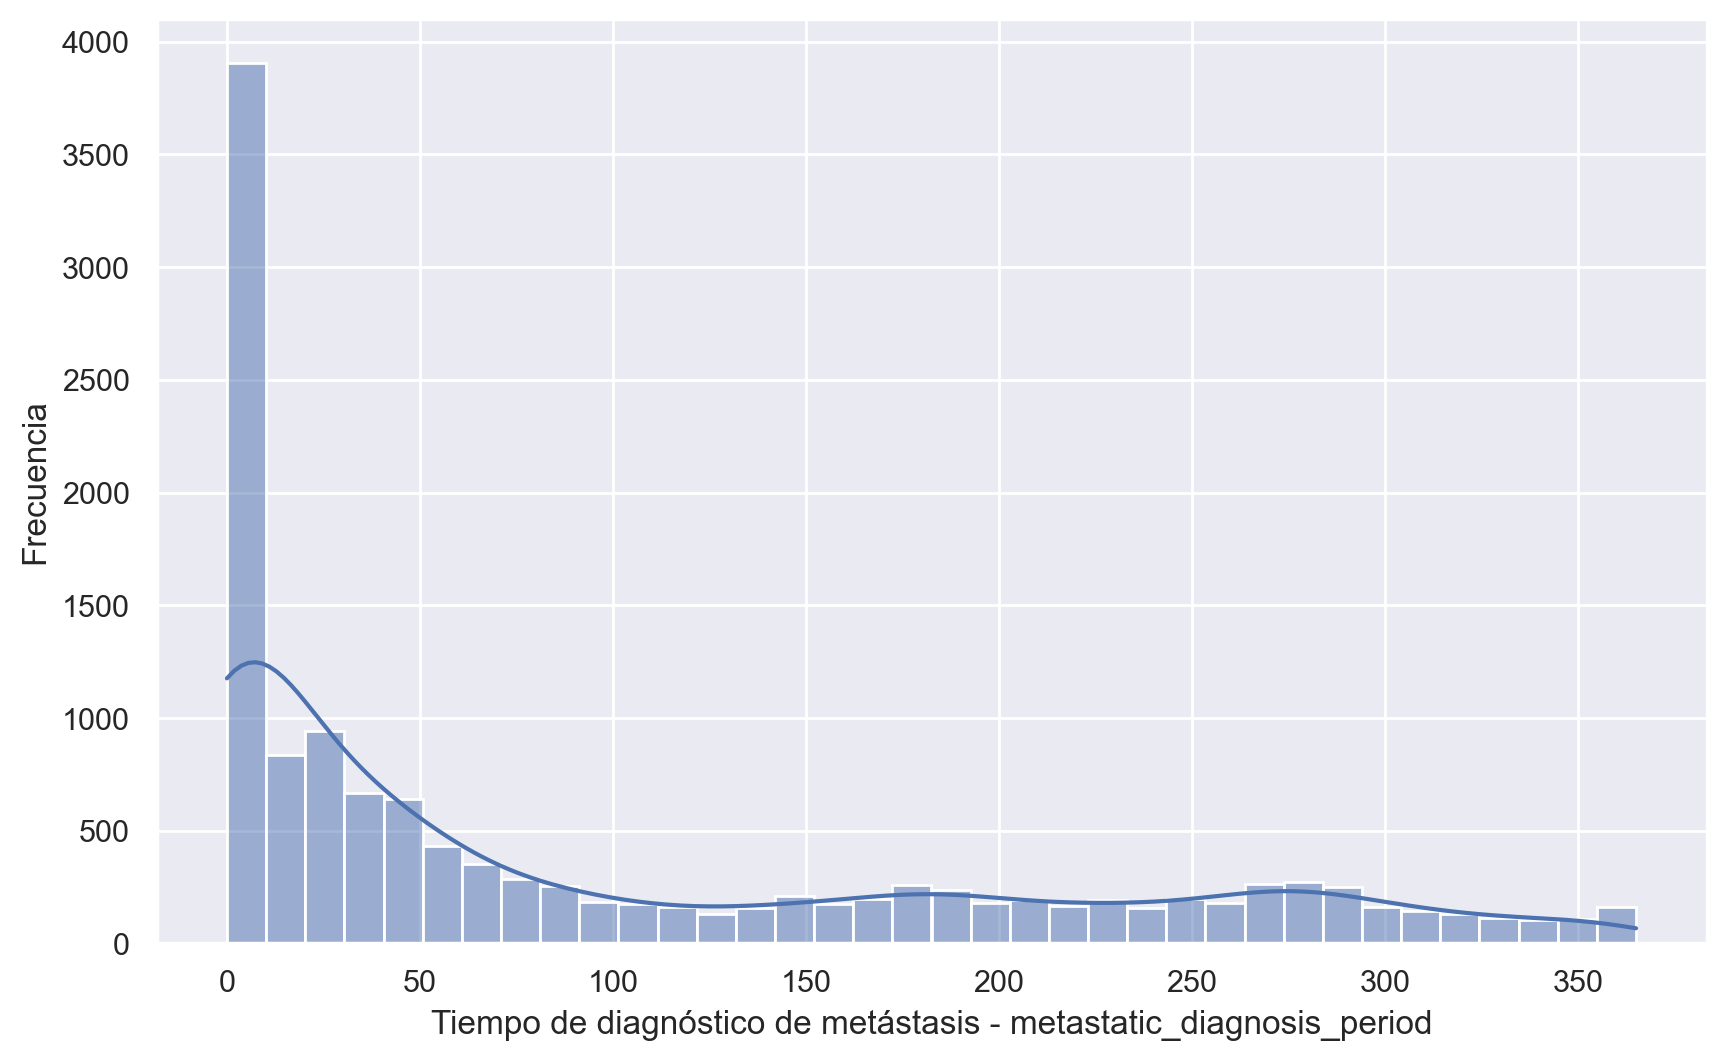

In [5]:
# Create the figure
plt.figure(figsize=(10, 6));

# Create a Histogram to display the distribution of the class variable
ax = sns.histplot(
    data=df_metastasis,
    x="metastatic_diagnosis_period",
    binwidth=10,
    kde=True
)

# Set a title and X/Y labels
ax.set(
    xlabel="Tiempo de diagnóstico de metástasis - metastatic_diagnosis_period",
    ylabel="Frecuencia"
);


A simple vista, se observa que **la mayoría de casos** (aproximadamente *4000*) han recibido un diagnóstico de metástasis en un plazo menor a **10 días**. Ahora bien hay una cola significativa en la distribución - hay una cantidad de casos considerables que tardan un tiempo mayor, habiendo algunos *outliers* que pueden llegar a tardar **más de 350 días**.

De esta forma, parece que salvo casos aislados, la gran mayoría de casos tienen un diagnóstico muy rápido. Ahora bien, si se discretiza la variable en varios conjuntos:

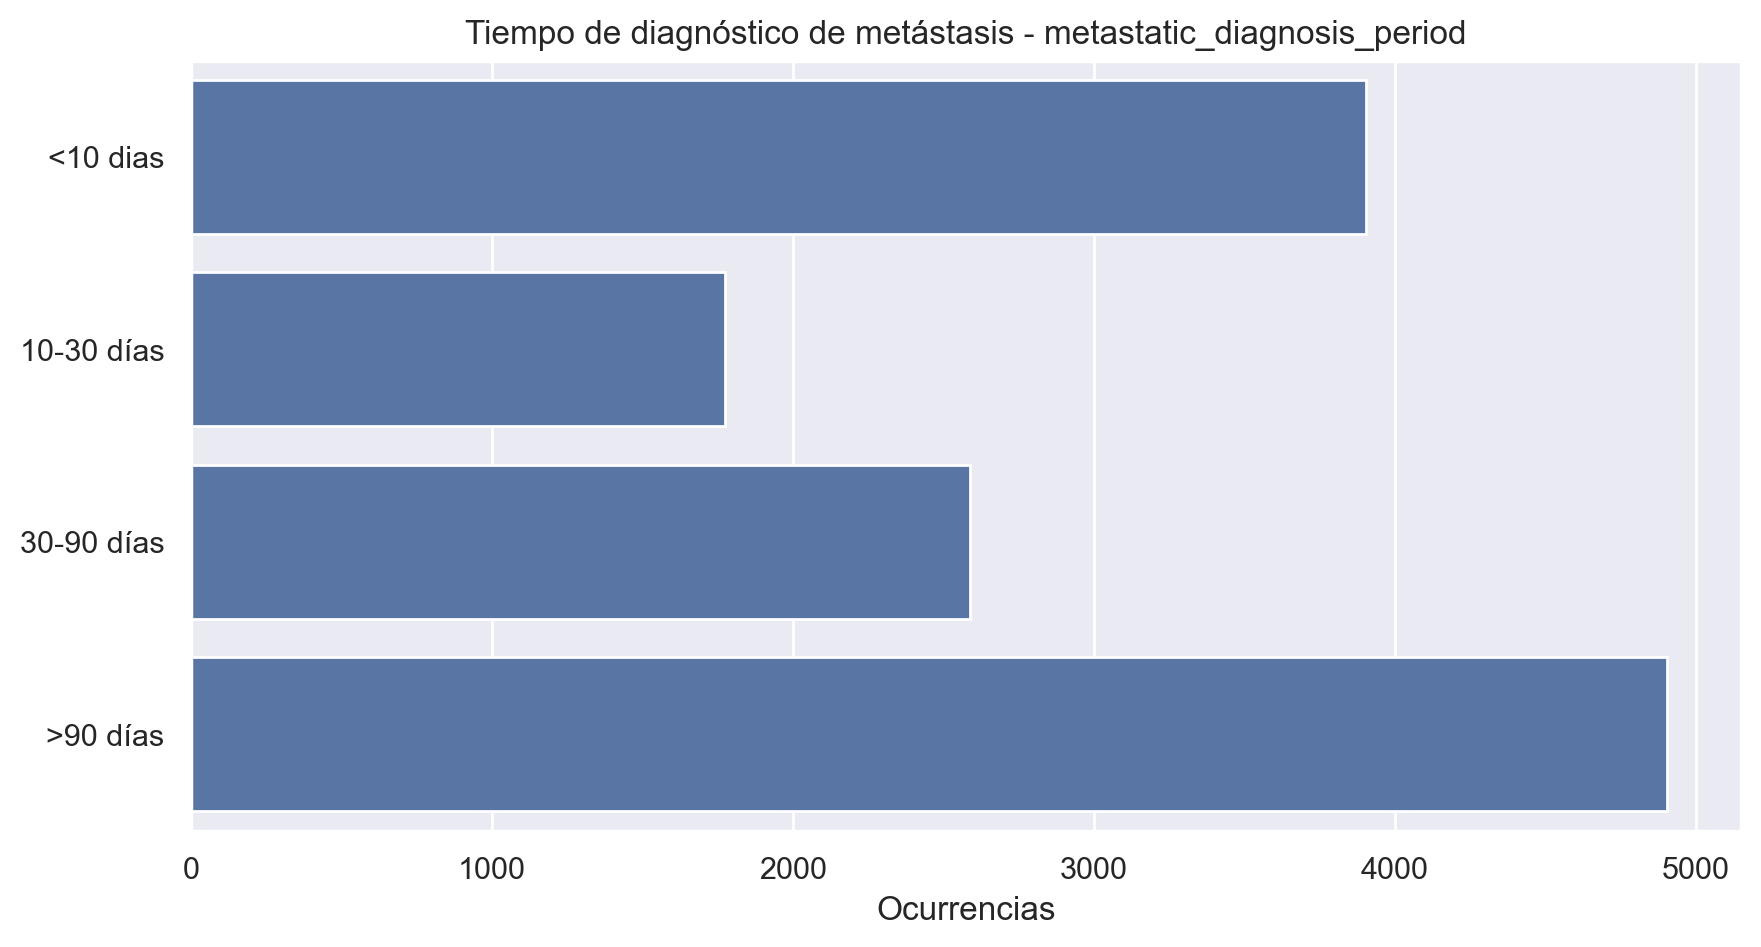

In [19]:
# Create the figure
plt.figure(figsize=(10, 5));

# Create a bar plot
ax = sns.countplot(
    # Data is divided into discrete ranges
    data = (pd.cut(df_metastasis["metastatic_diagnosis_period"],
           [-np.inf, 10, 30, 90, np.inf],
           labels=["<10 dias", "10-30 días", "30-90 días", ">90 días"]))
)

# Set a title and X/Y labels
ax.set(
    xlabel="Ocurrencias",
    ylabel="",
    title="Tiempo de diagnóstico de metástasis - metastatic_diagnosis_period"
);

Si se observa la distribución de esta forma, se evidencia que aunque una cantidad considerable de los casos reciben un diagnóstico breve, **la mayoría de los casos tarda más de 90 días en ser diagnosticado**.

En las siguientes secciones se estudiarán los atributos del conjunto de datos de forma más pormenorizada.

---

## 2.2. Estudio de variables categóricas

In [21]:
display(
    df_categorical.columns
)

Index(['patient_race', 'payer_type', 'patient_state', 'Region', 'Division',
       'patient_gender', 'breast_cancer_diagnosis_code',
       'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code',
       'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type'],
      dtype='object')

<a id="section2-2"></a>

## 2.3. Estudio de variables categóricas

<a id="section2-3"></a>

## 2.4. Estudio de variables numéricas

## 2.5. Estudio de variables geoeconómicas y climáticas